In [1]:
from platform import python_version
print(python_version())

3.8.8


In [1]:
import os
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
#from pysynphot import spectrum as S
from glob import glob
import itertools
import astrobase.astrokep

import limbdark as ld

import emcee
from emcee.utils import sample_ball

import scipy
import scipy.optimize as op
from scipy.constants import k,c,h
from scipy import integrate

from astropy import units as u
from astropy import constants as const
from astropy.constants import G,R_jup,R_sun,M_jup,M_sun,au,pc,sigma_sb, e

In [2]:
os.environ['CONDA_DEFAULT_ENV']

'dmtau'

# Definition and filter settings

In [3]:
def _bb_f(lam,T):
    '''
    Planck's law[W/m**2/Hz/sr] with fixed temperature
    [input]
    temp: star's effective temperature
    '''    
    nu = c/lam
    B_freq = 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))
    
    return B_freq


def _band_intensity(temp, filt):
    '''
    calculate mean intensity
    ref: Bessell(2011) eq.(A12)
    
    [Input]
    temp: effective temperature of the star[K]
    filt: filter profile downloaded from SVO filter profile
    '''
    lam = filt[0] * 1e-10
    bb_freq_med = []
    
    for i in range(len(filt)):
        nu = []
        ar_freq = []
        ar_bb_freq = []
        ar_freq = np.linspace(lam[i]-100e-10, lam[i]+100e-10, 10)
        ar_bb_freq = np.empty(len(ar_freq))
        for j in range(len(ar_freq)):
            ar_bb = []
            ar_bb = _bb_f(ar_freq[j],temp)
        bb_freq_med = np.median(ar_bb)

    nume = math.fsum(bb_freq_med*filt[1]/(c/lam))
    denomi = math.fsum(filt[1]/(c/lam))
    mean_intensity = nume/denomi
    
    return mean_intensity



class Mesh2D:
    def __init__(self, xrange, yrange, n):
        self.n = n
        self.x_min = xrange[0]
        self.x_max = xrange[1]
        self.y_min = yrange[0]
        self.y_max = yrange[1]
        self.x = np.linspace(xrange[0], xrange[1], n)
        self.y = np.linspace(yrange[0], yrange[1], n)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        

def _g_ratio(y, z, us, I_mean, xmin, xmax, ysmin, ysmax, zsmin, zsmax, ratio):
    #mu = cos(theta)
    u1,u2 = us

    mu = np.sqrt(1-(y**2+z**2))
    I_mu = (1 - u1*(1-mu) - u2*(1-mu)**2) * I_mean
    if xmin>0 or xmax>0:
        I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] = I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] * ratio
    
    I_mu[np.isnan(I_mu)] = 0.
    return I_mu

def _g_ldk(y, z, us, us_spot, I_mean, I_mean_spot, xmin, xmax, ysmin, ysmax, zsmin, zsmax):
    #mu = cos(theta)
    u1,u2 = us
    u1_s, u2_s = us_spot

    mu = np.sqrt(1-(y**2+z**2))
    I_mu = (1 - u1*(1-mu) - u2*(1-mu)**2) * I_mean
    I_mu_spot = (1 - u1_s*(1-mu) - u2_s*(1-mu)**2) * I_mean_spot

    if xmin>0 or xmax>0:
        I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] = I_mu_spot[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)]
    
    I_mu[np.isnan(I_mu)] = 0.
    return I_mu


def _ldc(ld_params, band, law='quadratic'):
    '''
    calculate limb-darkening coefficients
    
    [Input]
    ld_params :list of the parameters to calculate LDCs. [teff, uteff, logg, ulogg, feh, ufeh]
    band: filter name (ex. 'V' 'r*')
    '''
    teff, uteff, logg, ulogg, feh, ufeh = ld_params
    ldc_list     = []
    ldc_err_list = []
    ldp = []
    
    ldc = ld.claret(band, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4), law=law)
    ldp.append(ldc)
    #u1,u2
    ldc_list=[ldc[0],ldc[2]] #take first and third element of ldc 
    #uncertainties
    ldc_err_list=[ldc[1],ldc[3]] #take second and fourth element of ldc
    
    return ldc_list

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def _Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, math.cos(theta),-math.sin(theta)],
                   [ 0, math.sin(theta), math.cos(theta)]])
  
def _Ry(theta):
    return np.matrix([[ math.cos(theta), 0, math.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-math.sin(theta), 0, math.cos(theta)]])
  
def _Rz(theta):
    return np.matrix([[ math.cos(theta), -math.sin(theta), 0 ],
                   [ math.sin(theta), math.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

def _Ru(inc, phi):
    ux = math.cos(inc)
    uy = 0
    uz = math.sin(inc)
    
    alpha = 1 - math.cos(phi)
    beta  = math.sin(phi)
    
    return np.matrix([[alpha*ux**2 + math.cos(phi), alpha*ux*uy - beta*uz,      alpha*ux*uz + beta*uy],
                               [alpha*uy*ux + beta*uz,     alpha*uy**2 + math.cos(phi), alpha*uy*uz - beta*ux],
                               [alpha*uz*ux - beta*uy,      alpha*uz*uy + beta*ux,     alpha*uz**2+math.cos(phi)]])


[I 211006 14:43:25 utils:157] NumExpr defaulting to 8 threads.


['./Generic_Johnson.I.dat', './Generic_Johnson.R.dat', './Generic_Johnson.V.dat']


Text(0.5, 0, 'wavelength[m]')

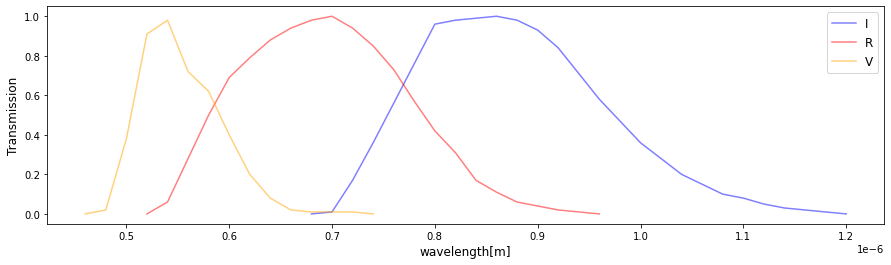

In [4]:
datadir = '.'
path    = os.path.join(datadir,'*.dat')
file_list = glob(path)
file_list = sorted(file_list)
print(file_list)

filt={}
bands = 'I,R,V'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_table(fname, delimiter=' ', parse_dates=True, header=None)
    #df = df.drop('Unnamed: 0',axis=1)
    #df = df.set_index('GJD-2450000')
    filt[b] = df
filt.keys()

lam_col =  'lambda'
trans_col  =  'transmission'

colors='b,r,orange'.split(',')
fig,ax = plt.subplots(1,1,figsize=(15,4))

n=0
for b,co in zip(bands,colors):
    df = filt[b]    
    lam_nm = df[0]*1e-10
    trans = df[1]
    
    ax.plot(lam_nm, trans, label=b, color=co, alpha=0.5)
    ax.set_ylabel('Transmission', fontsize=12)
    n+=1
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('wavelength[m]',fontsize=12)

# EMCEE

In [5]:
pd.options.display.float_format = '{:.5f}'.format
df_phot = pd.read_table('photometry.txt', sep='     ')
df_phot = df_phot[df_phot['JD']<2458507]
df_phot[:3]

<ipython-input-5-30c1e78407b8>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_phot = pd.read_table('photometry.txt', sep='     ')


JD source_name    fwhm  I_band_counts  V_band_counts  \
0 2458489.56528      dm_tau 4.27000        0.00000    29221.06200   
1 2458489.56616      dm_tau 3.86000        0.00000    29093.08500   
2 2458489.56693      dm_tau 3.81000        0.00000    29019.16900   

   R_band_counts  I_band_magnitudes  I_band_magnitudes_Error  \
0        0.00000            0.00000                  0.00000   
1        0.00000            0.00000                  0.00000   
2        0.00000            0.00000                  0.00000   

   V_band_magnitudes  V_band_magnitudes_Error  R_band_magnitudes  \
0           14.61800                  0.03600            0.00000   
1           14.61100                  0.03500            0.00000   
2           14.61200                  0.03400            0.00000   

   R_band_magnitudes_Error  
0                  0.00000  
1                  0.00000  
2                  0.00000

In [6]:
pd.options.display.float_format = '{:.5f}'.format
df_phot = pd.read_table('photometry.txt', sep='     ')
df_phot = df_phot[df_phot['JD']<2458507]

dfs    = {}
ts     = {}
mags   = {}
umags  = {}
for b in bands:
    dfs[b] = df_phot[df_phot[b+'_band_counts']!=0]
    dfs[b] = dfs[b].reset_index(drop=True)

    ts[b]    = dfs[b]['JD']
    mags[b]  = dfs[b][b + '_band_magnitudes']
    umags[b] = dfs[b][b + '_band_magnitudes_Error']


<ipython-input-6-39b5c225b538>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_phot = pd.read_table('photometry.txt', sep='     ')


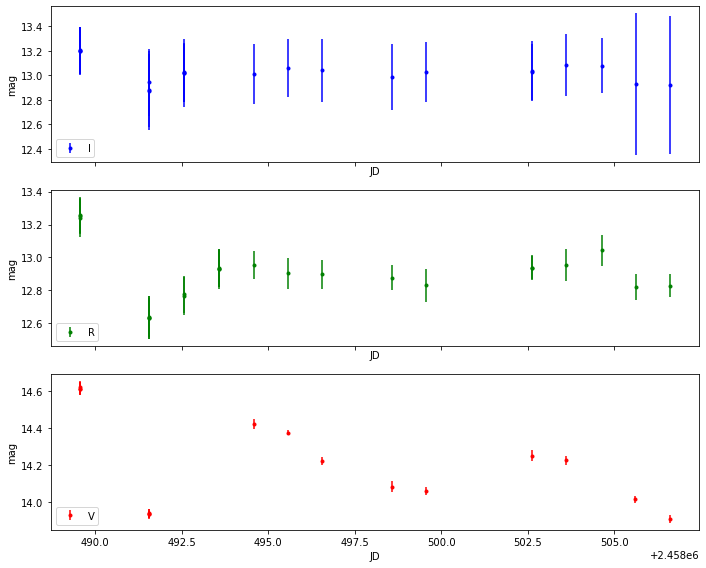

In [7]:
colors = ['b','g','r']

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(10,8), sharex=True)

n=0

for b,co in zip(bands,colors):
    
    data = dfs[b]
    
    time = data['JD']
    mag =  data[b+'_band_magnitudes']
    umag = data[b+'_band_magnitudes_Error']
    
    #plot with specific label (for legend) and color
    ax[n].errorbar(time, mag, yerr=umag, label=b, color=co, fmt='.')
    
    #add plot labels
    ax[n].set_xlabel('JD')
    ax[n].set_ylabel('mag')
    ax[n].legend(loc='lower left')
    
    #increase the axis counter
    n=n+1
    
#make better spacing
fig.tight_layout()

df_k2 = pd.read_csv('dmtau_eve.csv')
df_phot = pd.read_table('photometry.txt')
df_k2 = df_k2.drop('Unnamed: 0',axis=1)
print(df_k2[:3])

time = df_k2['time']
kpmag = astrobase.astrokep.keplerflux_to_keplermag(df_k2['flux'], f12=174000.0)
ukpmag = astrobase.astrokep.keplerflux_to_keplermag(df_k2['flux']+df_k2['uflux'], f12=174000.0) - kpmag

In [56]:
def _lc_ldk_new(params, time, period, dist, ngrid, nrho, filter_name):
    '''
    time            : observed time
    period          : period comes from 
    dist         [m]: distance
    ngrid           : mesh grid
    nrho            : the number of points along the circumference of the spot
    filter_name     : 'V','B' etc..
    
    '''
    phase = []
    r_s,r_spot,Teff,Tspot,q1e,q2e,q1s,q2s,inc,lat,lon = params 
    
    ueff = q_to_u(q1e,q2e)
    uspot = q_to_u(q1s,q2s)
    phi = math.pi/2 - inc
    for i in range(len(time)):
        phase.append(math.modf((time[i] - np.min(time))/period)[0]*2*np.pi)
    #phase = np.arange(0, 2*np.pi, phase_width)
    spot0_pos_ang = np.linspace(0, 2*np.pi, nrho)
    spot_origin = np.array([[1],[0],[0]])
    
    R = _Ry(lat) * _Rz(lon) * _Ry(phi)
    I_mean = _band_intensity(Teff,filt[filter_name])
    I_mean_spot = _band_intensity(Tspot, filt[filter_name])
    
    coord_all = []
    coord_min = []
    coord_max = []
    for i in range(len(phase)):

        ys        = [[] for _ in range(nrho)] 
        zs        = [[] for _ in range(nrho)] 
        spot0   = [[] for _ in range(nrho)] #matrix
        coord0 =  [[] for _ in range(nrho)] #matrix after rotation

        for j in range(nrho):
            x0 = np.sqrt(1 - r_spot**2)
            zs[j] = r_spot * np.sin(spot0_pos_ang[j])
            ys[j] = r_spot * np.cos(spot0_pos_ang[j])

            spot0[j] = np.array([[x0],[ys[j]],[zs[j]]])
            coord0[j] = (_Ru(inc, phase[i]) * (R * spot0[j]))

        coord_all.append(coord0)
        coord_max.append(np.amax(coord_all[i], axis=0))
        coord_min.append(np.amin(coord_all[i], axis=0))
        
        
    Zs = [[] for _ in range(len(phase))] 
    m = Mesh2D([-1,1], [-1, 1], ngrid)
    for i in range(len(phase)):
        Zs[i] = _g_ldk(m.X, m.Y, ueff, uspot, I_mean, I_mean_spot, coord_min[i][0],coord_max[i][0],coord_min[i][1],coord_max[i][1], coord_min[i][2], coord_max[i][2])


    sum_intensity_x = [[] for _ in range(len(phase))] 
    sum_intensity   = [[] for _ in range(len(phase))] 
    test_flux   = [[] for _ in range(len(phase))] 
    spot_mag        = [[] for _ in range(len(phase))] 
    
    test_flux_new  = [[] for _ in range(len(phase))] 
    for i in range(len(Zs)):
        for j in range(len(Zs[i])):
            sum_intensity_x[i].append(math.fsum(Zs[i][j]))
        sum_intensity = math.fsum(sum_intensity_x[i])
        r_d = r_s * R_sun/dist
        #test_flux = np.pi * sum_intensity/(ngrid**2) * 1/2 * (-math.cos(2*math.asin(r_d)) + 1)
        #arcsin's 3rd order Maclaurin expansion
        #arcsin = r_d + 1/6*r_d**3 + 3/40*r_d**5 + 5/112*r_d**7
        test_flux_new = np.pi * sum_intensity/(ngrid**2) * 1/2 * ( 2*(math.sin(math.asin(r_d)))**2)
        #print(test_flux_new)
        spot_mag[i].append(-2.5 * np.log10(test_flux_new*1e3)- 48.6)

    spot_mag_flat = list(itertools.chain.from_iterable(spot_mag))
        
    return spot_mag_flat

def obj(param, time, period, dist, ngrid, nrho, filter_name, mag, magerr):
    '''
    objective function: chi-squared
    '''
    mag_model = _lc_ldk_new(param, time, period, dist, ngrid, nrho, filter_name)
    
    return np.sum(((mag-mag_model)/magerr)**2)

def rms(mag,mag_model):
    residual = mag-mag_model
    #return np.sqrt((residual**2).sum()/residual.size)
    
    return np.sqrt(np.mean((residual)**2))

In [9]:
_Params_eff = [3500, 90, 4.43, 0.02, -0.14, 0.16]
_Params_spot = [500, 90, 4.43, 0.02, -0.14, 0.16]

_Ldc_eff = []
_Ldc_spot = []
for b in bands:
    _Ldc_eff.append(_ldc(_Params_eff,b))
    _Ldc_spot.append(_ldc(_Params_spot,b ))


#free
_R_s = 0.8 #R_sun
_R_spot = 0.35 #R_star
_Teff = 3500
_Tspot = 500
_Inc = np.pi/2 - np.pi/6
_Lat = 0
_P = 7.32 #day

#free but need to fix?
_Lon = np.pi/3

#_q1e, _q2e = ldc_eff[0]
#_q1s, _q2s = ldc_spot[0]

#fix
_D = 145*pc 
_Nrho = 20
_Ngrid = 100


In [57]:
mag_all = {} 
optimized_params = {}
bnds = ((0.,None), (0.,1.), (0.,None), (0.,None),(0.,1.),(0.,1.),(0.,1.),(0.,1.),(0.,np.pi/2),(-np.pi/2, np.pi/2),(-np.pi,np.pi))

n=0
for b,ue,us in zip(tqdm(bands),_Ldc_eff,_Ldc_spot):
    data = dfs[b]
    time_ = data['JD']
    mag_ =  data[b+'_band_magnitudes']
    umag_ = data[b+'_band_magnitudes_Error']


    q1e_,q2e_= u_to_q(ue[0],ue[1])
    q1s_,q2s_= u_to_q(us[0],us[1])

    params0 = [_R_s,_R_spot,_Teff,_Tspot,q1e_,q2e_,q1s_,q2s_,_Inc,_Lat,_Lon]
    print(params0)
    m_before_ = _lc_ldk_new(params0, time_, _P, _D, _Ngrid, _Nrho, b)
    #print(m_before_)
    rms_before_ = rms(mag_, m_before_)
    print('rms before: {:.4f}'.format(rms_before_))

    #optimize parameters
    result_ = op.minimize(obj, params0, args=(time_,_P,_D,_Ngrid,_Nrho,b,mag_,umag_),method='L-BFGS-B',bounds=bnds)

    params_after_ = np.copy(result_.x)
    m_after_ = _lc_ldk_new(params_after_, time_, _P, _D, _Ngrid, _Nrho, b)
    #print(m_after_)

    dfs[b]['model'] = m_after_
    rms_after_ = rms(mag_, m_after_)
    print('rms after: {:.4f}'.format(rms_after_))
   
    #dict of optimized transit parameters to be used later
    mag_all[b] = m_after_
    optimized_params[b] = params_after_
    n+=1


  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-3-ac421c7bf772>:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))


[0.8, 0.35, 3500, 500, 0.4065868610618896, 0.21840058939689067, 0.8640832251229936, 0.5349619799467226, 1.0471975511965979, 0, 1.0471975511965976]
rms before: 0.0953


 33%|███▎      | 1/3 [00:13<00:26, 13.00s/it]

rms after: 0.0781
[0.8, 0.35, 3500, 500, 0.5233717564846968, 0.28356127092398276, 0.9196932944210878, 0.6263999945526955, 1.0471975511965979, 0, 1.0471975511965976]
rms before: 0.3533


 67%|██████▋   | 2/3 [00:30<00:14, 14.31s/it]

rms after: 0.1516
[0.8, 0.35, 3500, 500, 0.5883651655651225, 0.279195069054526, 0.9468441677822718, 0.7501780364478964, 1.0471975511965979, 0, 1.0471975511965976]
rms before: 0.4935


100%|██████████| 3/3 [00:41<00:00, 13.43s/it]

rms after: 0.2236


I
R
V


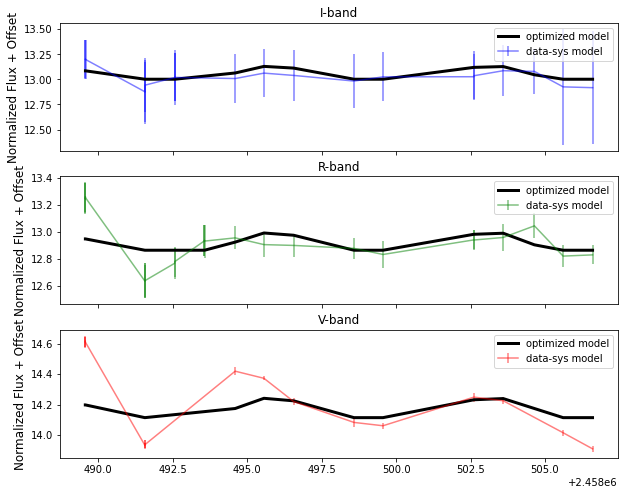

In [58]:
fig,ax = plt.subplots(3,1,figsize=(10,8), sharex=True)
n=0
for b,co in zip(bands,colors):
    print(b)
    data = dfs[b]

    time_ = data['JD']
    mag_ =  data[b+'_band_magnitudes']
    umag_ = data[b+'_band_magnitudes_Error']
    model_ = data['model']

    #plot flux raw data
    ax[n].errorbar(time_, mag_, yerr=umag_, 
                    label='data-sys model', alpha=0.5, color=co) 

    ax[n].plot(time_, model_, 'k-', lw=3, label='optimized model')
    ax[n].set_title('{}-band'.format(b), fontsize=12)
    ax[n].legend(fontsize=10)
    ax[n].set_ylabel('Normalized Flux + Offset', fontsize=12)
    n+=1

#plt.savefig('optimized_model.png')

Even I tried several combinations of the parameters, the model didn't consistent with R and V-band. So I changed the longitude from 0 to np.pi/3. I need to consider the combinations....

In [59]:
optimized_params

{'I': array([7.14974978e-01, 3.50000000e-01, 3.50001461e+03, 5.00000000e+02,
        3.69977703e-03, 9.22604486e-04, 8.64083225e-01, 5.34961980e-01,
        1.04719755e+00, 0.00000000e+00, 1.04719755e+00]),
 'R': array([8.38152311e-01, 3.50000000e-01, 3.50000001e+03, 5.00000000e+02,
        3.63081222e-04, 3.05365656e-02, 9.19693294e-01, 6.26399995e-01,
        1.04719755e+00, 0.00000000e+00, 1.04719755e+00]),
 'V': array([5.93274139e-01, 3.50000000e-01, 3.51101260e+03, 5.00000000e+02,
        0.00000000e+00, 0.00000000e+00, 9.46844168e-01, 7.50178036e-01,
        1.04719755e+00, 0.00000000e+00, 1.04719755e+00])}

In [61]:
def logprior(full_params):
    r_s,r_spot,Teff,Tspot,q1e,q2e,q1s,q2s,inc,lat,lon = full_params
    
    if  (q1e < 0 or q1e > 1) or \
        (q2e < 0 or q2e > 1) or \
        (q1s < 0 or q1s > 1) or \
        (q2s < 0 or q2s > 1) or \
        (inc < 0 or inc > np.pi/2 ) or \
        (lat < -np.pi/2 or lat > np.pi/2) or \
        (lon < -np.pi or lon > np.pi ):
        return -np.inf
    
    lp = 0
    
    return lp 


def logprob(full_params, 
                 time_list, 
                 period, 
                 dist, 
                 ngrid, 
                 nrho, 
                 filters, 
                 mag_list, 
                 magerr_list):
    
    t1,t2,t3          = time_list
    mag1,mag2,mag3    = mag_list
    umag1,umag2,umag3 = magerr_list
    
    r_s,r_spot,Teff,Tspot,\
    q1e_i,q2e_i,q1e_r,q2e_r,q1e_v,q2e_v,\
    q1s_i,q2s_i,q1s_r,q2s_r,q1s_v,q2s_v,\
    inc,lat,lon = full_params
    
    #w0g: offset; w1g: airmass; w2g:dx; w3g:dy
    theta1 = [r_s,r_spot,Teff,Tspot,q1e_i,q2e_i,q1s_i,q2s_i,inc,lat,lon]
    theta2 = [r_s,r_spot,Teff,Tspot,q1e_r,q2e_r,q1s_r,q2s_r,inc,lat,lon]
    theta3 = [r_s,r_spot,Teff,Tspot,q1e_v,q2e_v,q1s_v,q2s_v,inc,lat,lon]
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, period, dist, ngrid, nrho, filters[0], mag1, umag1)
    ll += loglike(theta2, t2, period, dist, ngrid, nrho, filters[1], mag2, umag2)
    ll += loglike(theta3, t3, period, dist, ngrid, nrho, filters[2], mag3, umag3)

    
    lp  = logprior(theta1)
    lp += logprior(theta2)
    lp += logprior(theta3)
    
    if np.isnan(ll).any():
        print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll



#negative log prob
nlp = lambda *x: -logprob(*x)
    
    
def loglike(params_full, time, period, dist, ngrid, nrho, filter_name, mag, magerr):
    '''
    * computes the log likelihood given the optimized transit and model parameters
    * either or both transit and systematics models can also be returned
    '''
    
    #assert err is not a single number
    m = _lc_ldk_new(params_full, time, period, dist, ngrid, nrho, filter_name)
    
    resid = mag - m
    #print('resid:', resid)
    #make sure no 0 in err
    assert magerr.any() != 0

    N = len(resid)
    
        
    return -0.5*(N*np.log(2*np.pi) + 2*np.sum(np.log(magerr)) + np.sum((resid/magerr)**2))

In [62]:
r_s,r_spot,Teff,Tspot,q1e_i,q2e_i,q1s_i,q2s_i,inc,lat,lon = optimized_params['I']
_,_,_,_,q1e_r,q2e_r,q1s_r,q2s_r,_,_,_ = optimized_params['R']
_,_,_,_,q1e_v,q2e_v,q1s_v,q2s_v,_,_,_ = optimized_params['V']

times    = []
mags   = []
magerrs     = []

#bands2 = 'I,R'.split(',')

for b in bands:
    #sys mod params
    df = dfs[b]
    times.append(df['JD'])
    mags.append(df[b+'_band_magnitudes'])
    magerrs.append(df[b+'_band_magnitudes_Error']) 
    
    
    
full_params = [r_s,r_spot,Teff,Tspot,\
              q1e_i,q2e_i,q1e_r,q2e_r,q1e_v,q2e_v,\
              q1s_i,q2s_i,q1s_r,q2s_r,q1e_v,q2e_v,\
              inc,lat,lon]

param_names='r_s,r_spot,Teff,Tspot,q1e_i,q2e_i,q1e_r,q2e_r,q1e_v,q2e_v,q1s_i,q2s_i,q1s_r,q2s_r,q1s_v,q2s_v,inc,lat,lon'.split(',')

In [64]:
logprob(full_params,times,_P,_D,_Ngrid,_Nrho,bands,mags,magerrs)

<ipython-input-3-ac421c7bf772>:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))


-2676.8789604158214

In [67]:
nwalkers = 100
ndim = len(full_params)
p0=sample_ball(full_params,std=[1e-2]*ndim,size=nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=(times,_P,_D,_Ngrid,_Nrho,bands,mags,magerrs))

In [68]:
for p in tqdm(sampler.sample(p0,iterations=50)):
    pass


0it [00:00, ?it/s]<ipython-input-3-ac421c7bf772>:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
<ipython-input-3-ac421c7bf772>:124: RuntimeWarning: invalid value encountered in sqrt
  u1 = 2 * np.sqrt(q1) * q2
<ipython-input-3-ac421c7bf772>:125: RuntimeWarning: invalid value encountered in sqrt
  u2 = np.sqrt(q1) * (1 - 2*q2)
<ipython-input-56-05738a2aa744>:72: RuntimeWarning: divide by zero encountered in log10
  spot_mag[i].append(-2.5 * np.log10(test_flux_new*1e3)- 48.6)
/home/yterada/anaconda3/envs/dmtau/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]

1it [00:15, 15.88s/it]
2it [00:24, 13.72s/it]
3it [00:32, 12.11s/it]
4it [00:41, 11.01s/it]
5it [00:49, 10.28s/it]
6it [00:58,  9.74s/it]
7it [01:06,  9.37s/it]
8it [01:15,  9.18s/it]
9it [01:24,  9.01s/it]
10it [01:32,  8.90s/it]
11it [01:41,  8.75s/it]
12it [01:49,  8.66s/it]
13it [01:58,

Text(0.5, 0, 'nsteps')

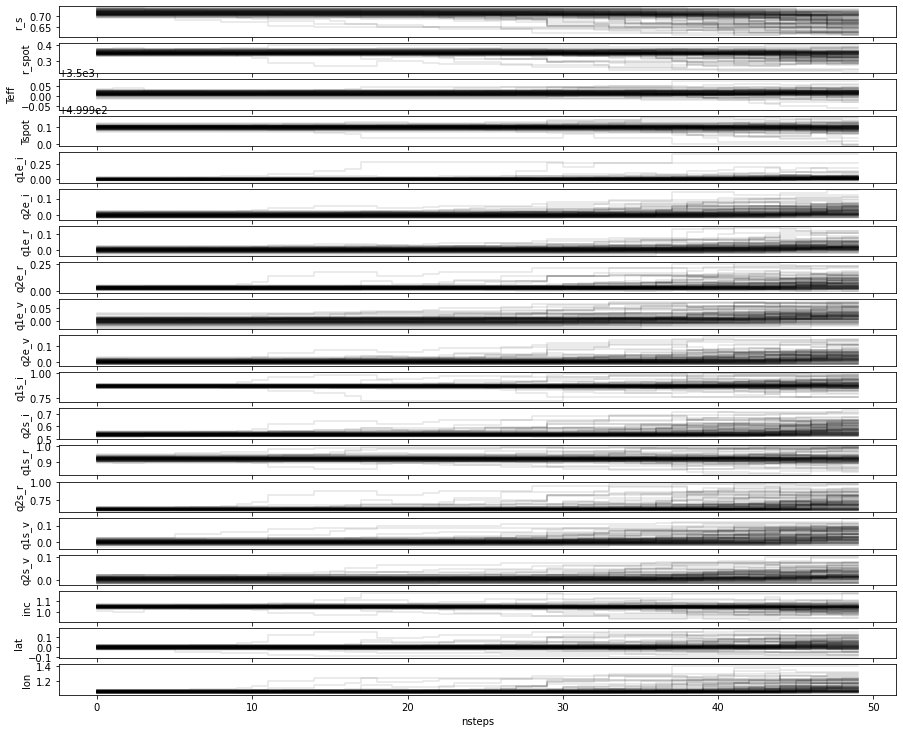

In [69]:
chain = sampler.chain

nsteps, nwalkers, ndim = chain.shape
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=0.1) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

In [41]:
#remove chain
chain2=chain[:,250:2000,:]

Text(0.5, 0, 'nsteps')

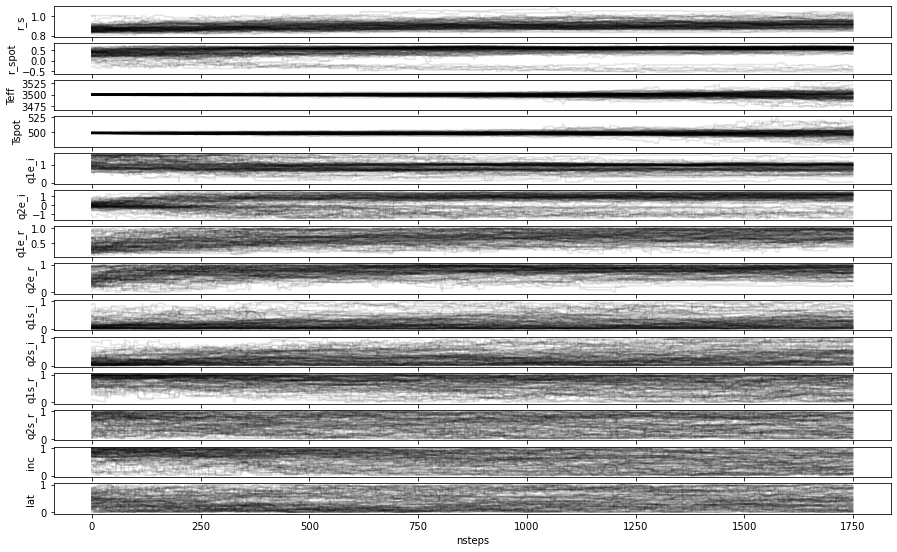

In [44]:
nsteps, nwalkers, ndim = chain2.shape
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=0.1) for i,c in enumerate(chain2.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

In [45]:
flatchain=chain2.reshape((-1,ndim))

[W 211006 19:48:11 core:593] Too few points to create valid contours


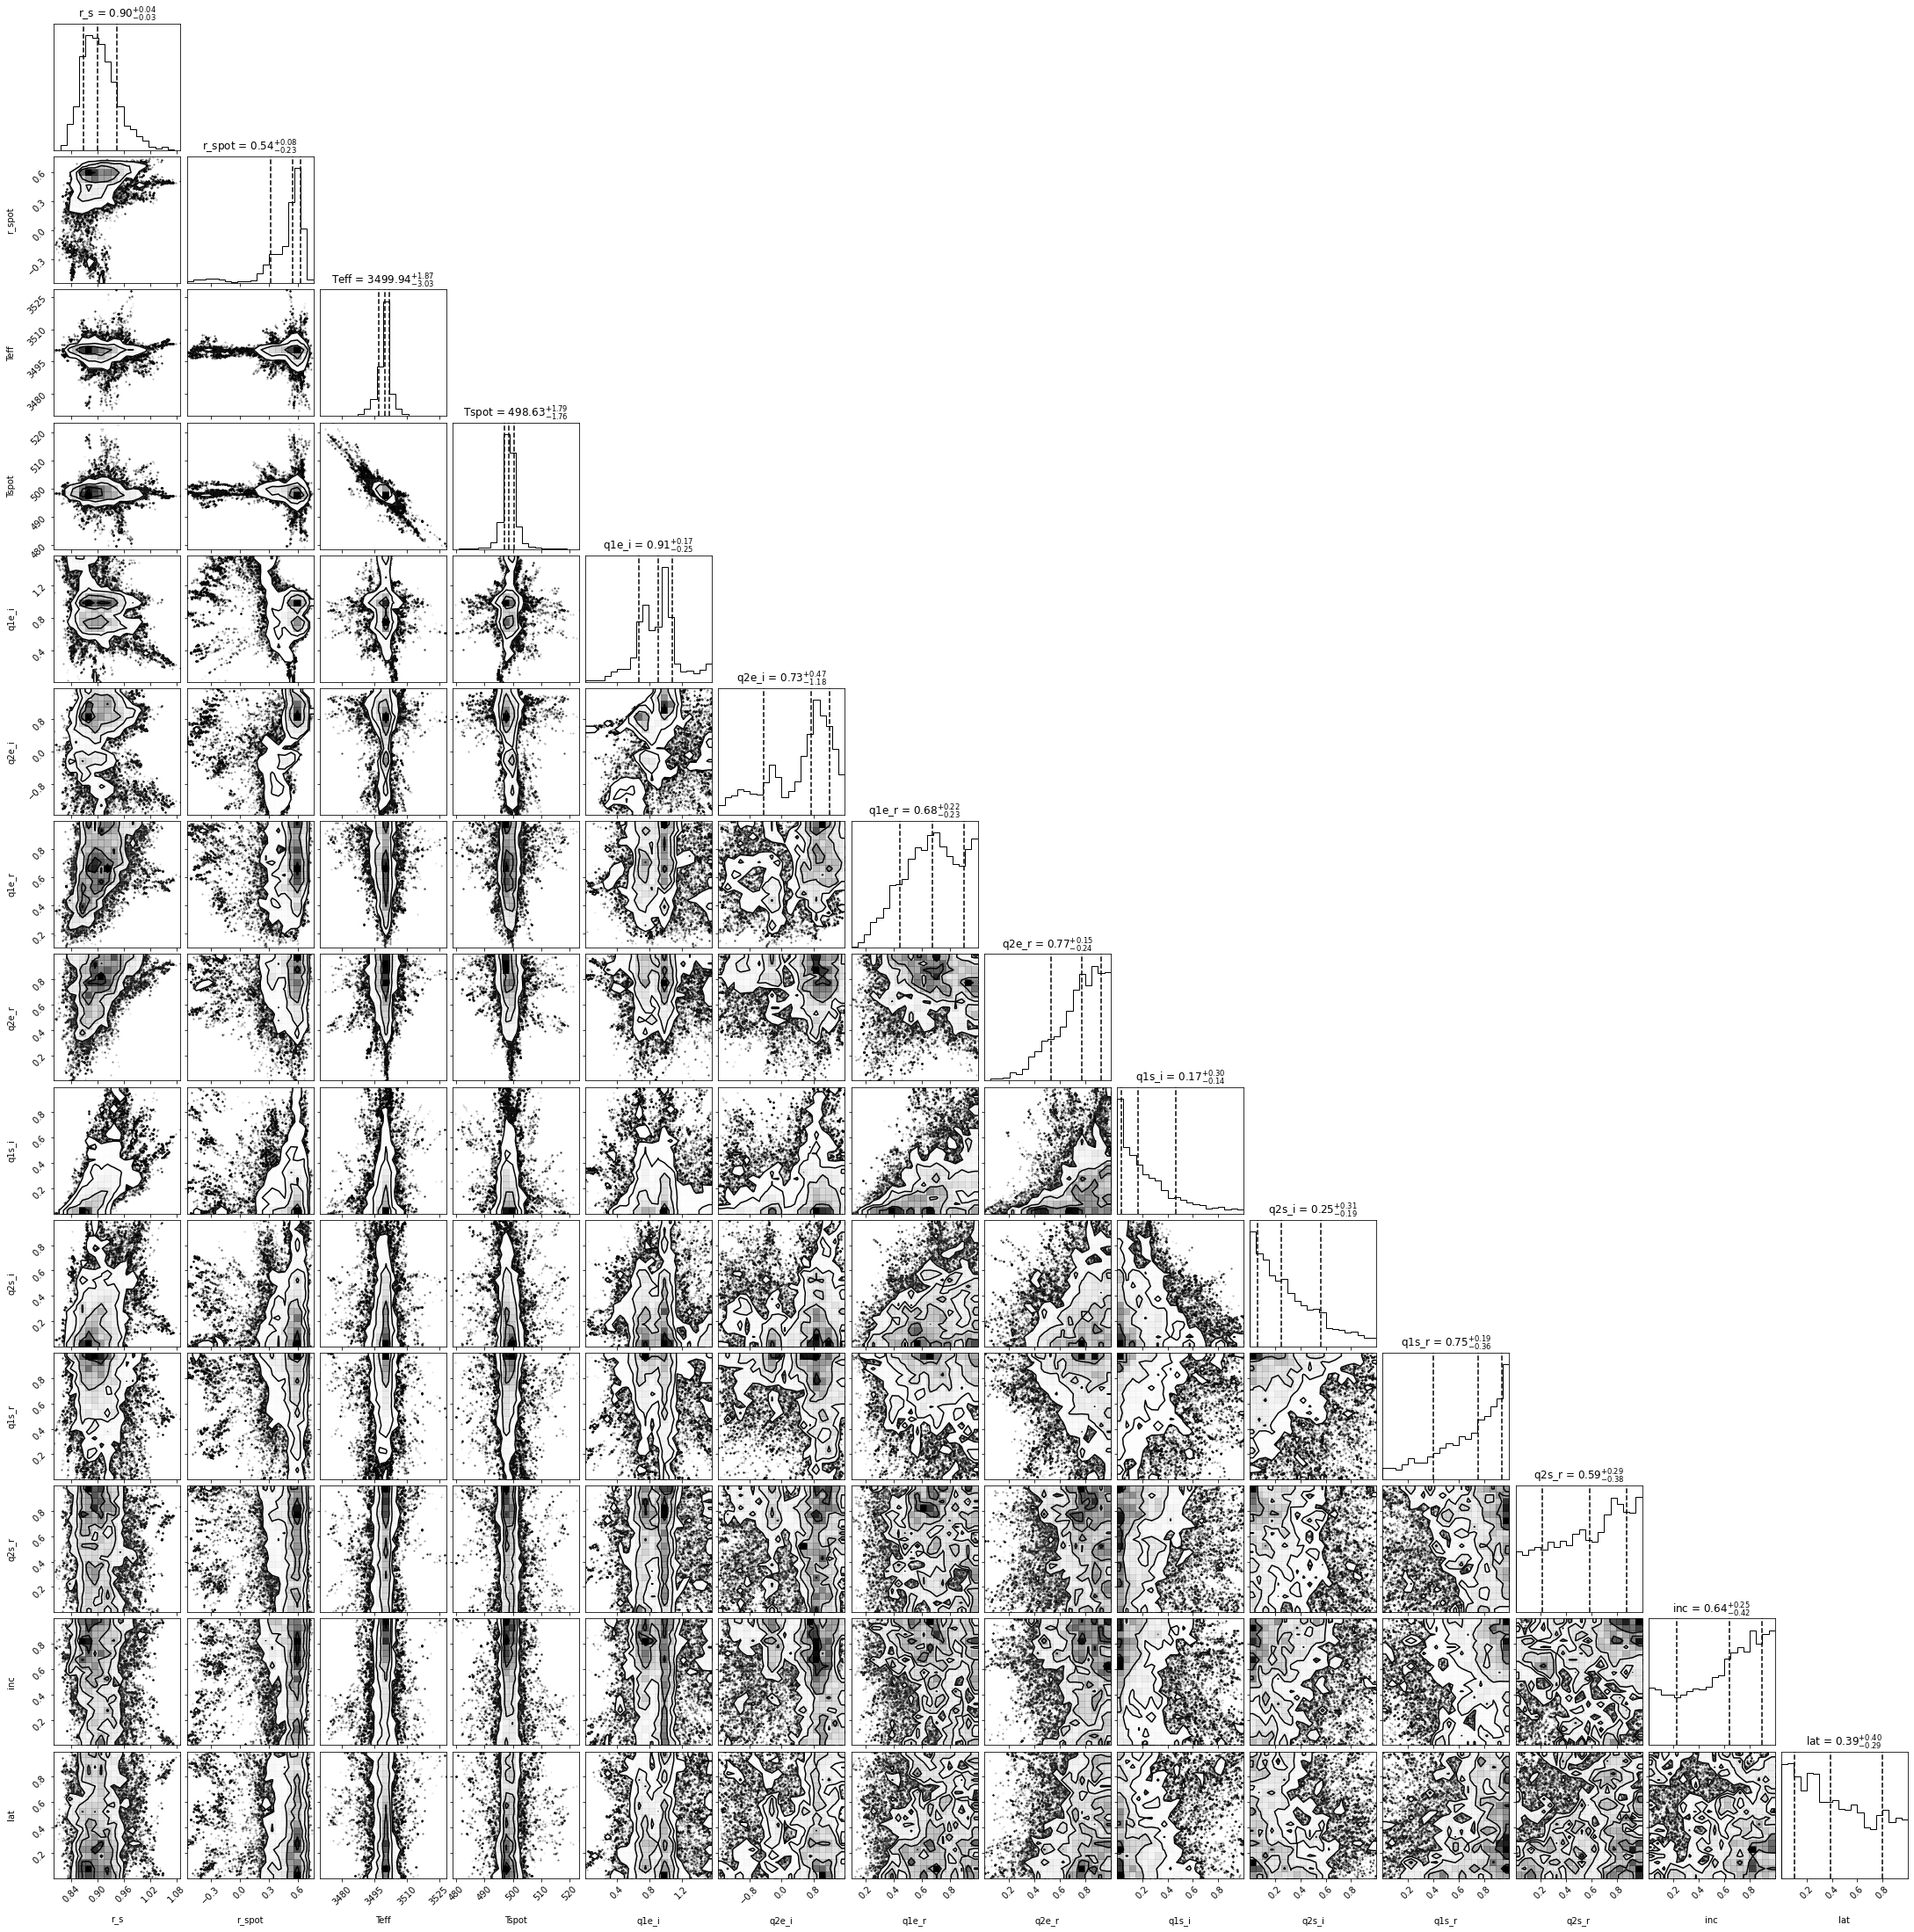

In [47]:
import corner 
flatchain=chain2.reshape((-1,ndim))
fig2=corner.corner(flatchain, labels=param_names, 
                  quantiles=[0.16, 0.5, 0.84], 
                  show_titles=True, title_kwargs={"fontsize": 12});

In [48]:
import gzip

with gzip.GzipFile('chain-zdx-1.npy.gz', 'w') as g1:
    np.save(g1, sampler.chain)
    
with gzip.GzipFile('lnp-zdx-1.npy.gz', 'w') as g2:
    np.save(g2, sampler.flatlnprobability)

r_s: 0.9002-0.0336+0.0437


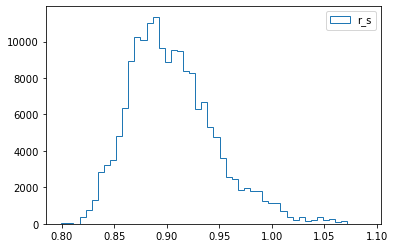

In [52]:
mid = []
upper = []
lower = []
i=0
m,l,r = np.percentile(chain2[:,:,i].flatten(), [50,16,84])

minus = m - l
plus  = r - m
print("{}: {:.4f}-{:.4f}+{:.4f}".format(param_names[i], m, minus, plus))
mid.append(m)
lower.append(minus)
upper.append(plus)
plt.hist(chain2[:,:,i].flatten(), bins=50, label=param_names[i], histtype="step");
plt.legend()

r_spot: 0.5418-0.2272+0.0810


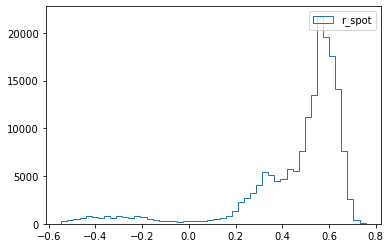

In [53]:
mid = []
upper = []
lower = []
i=1
m,l,r = np.percentile(chain2[:,:,i].flatten(), [50,16,84])

minus = m - l
plus  = r - m
print("{}: {:.4f}-{:.4f}+{:.4f}".format(param_names[i], m, minus, plus))
mid.append(m)
lower.append(minus)
upper.append(plus)
plt.hist(chain2[:,:,i].flatten(), bins=50, label=param_names[i], histtype="step");
plt.legend()

Teff: 3499.9353-3.0317+1.8720


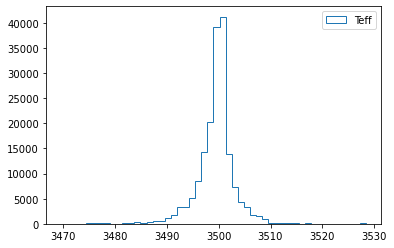

In [54]:
mid = []
upper = []
lower = []
i=2
m,l,r = np.percentile(chain2[:,:,i].flatten(), [50,16,84])

minus = m - l
plus  = r - m
print("{}: {:.4f}-{:.4f}+{:.4f}".format(param_names[i], m, minus, plus))
mid.append(m)
lower.append(minus)
upper.append(plus)
plt.hist(chain2[:,:,i].flatten(), bins=50, label=param_names[i], histtype="step");
plt.legend()

Tspot: 498.6320-1.7635+1.7932


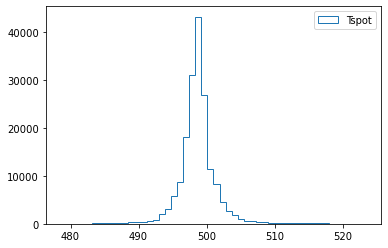

In [55]:
mid = []
upper = []
lower = []
i=3
m,l,r = np.percentile(chain2[:,:,i].flatten(), [50,16,84])

minus = m - l
plus  = r - m
print("{}: {:.4f}-{:.4f}+{:.4f}".format(param_names[i], m, minus, plus))
mid.append(m)
lower.append(minus)
upper.append(plus)
plt.hist(chain2[:,:,i].flatten(), bins=50, label=param_names[i], histtype="step");
plt.legend()